#### **Welcome to Assignment 3 on Deep Learning for Vision.**


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!


### Question 1: Resnet-18 from scratch

In this question, you'll have to code Resnet-18 from scratch (we have provided a lot of starter code), this'll help you get a hold on how to code an architecture with skip connections and blocks of layers.

It's suggested you first briefly understand how the Resnet architecture is defined originally before you start with this question. We do take inspiration from the original Pytorch implementation, but if you try peeking into the original source code in the library, it'll confuse you more than helping!

Train the model for 15 epochs. Report the train, test loss and accuracies. Also plot epochs vs loss. 

**Sidenote:** As this assignment is mainly focused on learning things, we train the models only for a small number of epochs and don't focus on hyper-parameter tuning. When you start using deep learning in real-world applications and competitions, hyper-parameter tuning plays a decent role!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [2]:
# check availability of GPU and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define a set of transforms for preparing the dataset
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
        ])
  # use random crop with image size fo 32 and padding of 8 
        # flip the image horizontally (use pytorch random horizontal flip)
        # convert the image to a pytorch tensor
        # normalise the images with mean and std of the dataset 
        # mean: (0.4914, 0.4822, 0.4465) std: (0.2023, 0.1994, 0.2010)


# define transforms for the test data: Should they be same as the one used for train? 
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
        ])        # convert the image to a pytorch tensor
        # normalise the images with mean and std of the dataset 
        # mean: (0.4914, 0.4822, 0.4465) std: (0.2023, 0.1994, 0.2010)

use_cuda = torch.cuda.device(device) #torch.cuda.set_device(1) # if you have acess to a GPU, enable it to speed the training 

In [3]:
# Load the CIFAR-10 training, test datasets using `torchvision.datasets.CIFAR10`
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.CIFAR10(root='./data', 
                                           train=True, 
                                           transform=transform_train,  
                                           download=True)
test_dataset = datasets.CIFAR10(root='./data', 
                                           train=False, 
                                           transform=transform_test,  
                                           download=True)
#### YOUR CODE ENDS HERE ####


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=32, 
                                          shuffle=False)
#### YOUR CODE ENDS HERE ####

In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    # define a convolutional layer with a kernel size of 3x3
    # use stride, groups values passed to the function along with a padding of 1 and dilatio of 1
    # set bias to False
    #### YOUR CODE STARTS HERE ####
    layer = torch.nn.Conv2d(in_channels = in_planes , out_channels = out_planes , kernel_size = 3, stride= stride , padding= 1 , dilation= 1 , groups= groups, bias= False)
    #### YOUR CODE ENDS HERE ####
    return layer


def conv1x1(in_planes, out_planes, stride=1):
    # define a convolutional layer with a kernel size of 1x1
    # use stride value passed to the function
    # set bias to False
    # leave all other parameters to default values
    #### YOUR CODE STARTS HERE ####
    layer = torch.nn.Conv2d(in_channels = in_planes , out_channels = out_planes , kernel_size = 1, stride= stride , bias= False)
    #### YOUR CODE ENDS HERE ####
    return layer

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64):
        super(BasicBlock, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define batch-norm layer to for easy use (you don't have to call it here)
        norm_layer = nn.BatchNorm2d
        # define a 3x3 convolution layer with inplanes as in-channels and planes and out_channels, use the passed value of stride
        self.conv1 = conv3x3(inplanes,planes,stride)
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn1 = norm_layer(planes)
        # define a relu layer with inplace set to True
        self.relu = torch.nn.ReLU(inplace=True)
        # define a 3x3 convolution layer with inplanes as in-channels and planes and out_channels
        self.conv2 = conv3x3(planes, planes)
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn2 = norm_layer(planes)
        #### YOUR CODE ENDS HERE ####
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        # make a copy of nput (for using them in skip connections)
        identity = x

        out = self.conv1(x)
        
        out = self.bn1(out)
        
        out = self.relu(out)
        
        out = self.conv2(out)
        
        out = self.bn2(out)

        # pass the input through, conv1->bn1->relu->conv2->bn2
 
        #### YOUR CODE ENDS HERE ####

        if self.downsample is not None:
            identity = self.downsample(identity) #in code it was x

        #### YOUR CODE STARTS HERE ####
        # add the skip connection
        out = out + identity
        # use a relu activation on `out`
        out = self.relu(out)
        #### YOUR CODE ENDS HERE ####

        return out

In [10]:
class ResNet18(nn.Module):
  # first start with make_layer method followed by __init__, forward methods
    def __init__(self, block, num_classes=10, groups=1):
        super(ResNet18, self).__init__()
        
        # define batch-norm layer to for easy use (you don't have to call it here)
        #### YOUR CODE STARTS HERE ####
        norm_layer = nn.BatchNorm2d
        #### YOUR CODE ENDS HERE ####
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = 64
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with number of image channels as in-channels and inplanes ans out-channles,
        # use a kernel size of 7, stride of 2, padding of 3 and set bias to False 
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = self.inplanes , kernel_size=7, stride=2, padding=3 , bias= False) #hello here
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn1 = norm_layer(self.inplanes)
        # define a relu layer with inplace set to True
        self.relu = nn.ReLU(inplace = True)
        # define a maxpool layer with kernel size of 3, stride of 2, padding of 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # complete the make layer method below and use it with the block value passed to init
        # with 64 planes and 2 blocks
        self.layer1 = self._make_layer( block, 64, 2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 128 planes and 2 blocks and a stride value of 2
        self.layer2 = self._make_layer( block, 128, 2, stride = 2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 256 planes and 2 blocks and a stride value of 2
        self.layer3 = self._make_layer( block, 256, 2, stride = 2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 512 planes and 2 blocks and a stride value of 2
        self.layer4 = self._make_layer( block, 512, 2, stride = 2)
        # define  adaptive avergae pooling layer with output size (1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #### YOUR CODE ENDS HERE ####
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        #### YOUR CODE STARTS HERE ####        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # initialise the weights with kaiming normal, set mode to fan out and 
                # non_linearity to the activation function you used above
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity = 'relu')
            elif isinstance(m, nn.BatchNorm2d):
                # initialise weights with a value of 1 and bias with a value of 0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
         #### YOUR CODE ENDS HERE ####

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)#norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            #### YOUR CODE STARTS HERE ####
            # append the blocks to layers, leave stride and downsample to default values
            
            layers.append(block(self.inplanes, planes,groups = self.groups,
                            base_width = self.base_width)) # 256 -> 64, 64*4 (256) again
            #### YOUR CODE ENDS HERE ####
        
        return nn.Sequential(*layers)

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        # complete the forward pass
        # order of layers: conv1->bn1->relu->maxpool->layer1->layer2->layer3->layer4->avgpool->fc
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        #### YOUR CODE ENDS HERE ####
        return x

In [11]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use cross entropy in pytorch)
        loss = F.cross_entropy(output,target)
        #loss = nn.CrossEntropyLoss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
      
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*32) + ((epoch-1)*len(train_loader.dataset)))

In [12]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(15)]
model = ResNet18(BasicBlock, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().cuda()
## Define Adam Optimiser with a learning rate of 0.01
optimizer =  torch.optim.Adam(model.parameters(),lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 16):
    train(model, device, train_dataloader, criterion, optimizer, epoch)
    test(model, device, test_dataloader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.698631
Train Epoch: 1 [640/50000 (1%)]	Loss: 4.090452
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.281761
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.824023
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.421563
Train Epoch: 1 [3200/50000 (6%)]	Loss: 3.117036
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.343880
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.136995
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.954476
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.084251
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.876630
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.915765
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.911905
Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.878777
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.799546
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.973726
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.164342
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.839983
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.431440
Train Epoch: 1 [12160/50000 (24%)]	Loss: 1.986732
Train Epoch: 1 [12800/50000 

### Loss Values
Train Loss (final) = 0.217101

Test Loss = Average loss: 0.0363, Accuracy: 7341/10000 (73%)

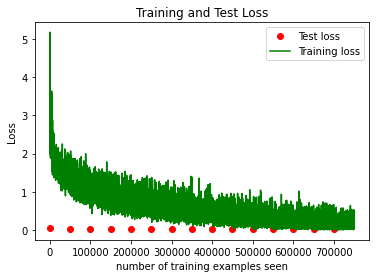

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt


plt.plot(test_counter, test_losses, 'ro', label='Test loss')
plt.plot(train_counter, train_losses, 'g', label='Training loss')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')

plt.title('Training and Test Loss')
plt.legend()

plt.figure()


plt.show()

### Question 2
Plot the saliency map from Pretrained Vgg19 model of the given image using "simple Gradient" method. Find out and print the mean and maximum  pixel intensity values of the generated saliency map. Note that the input image has 3 channels. To derive a single class saliency value for each pixel (i, j),  take the maximum magnitude across all colour channels.




Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


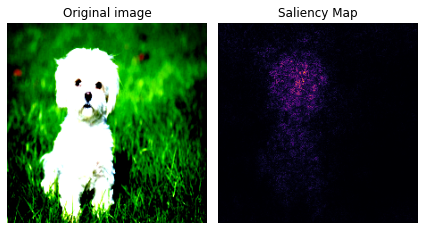


The mean pixel intensity of the generated saliency map :  0.01727925054728985
The max pixel intensity of the generated saliency map :  0.6645449995994568


In [15]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Opening the image
img = Image.open('input.jpg')


# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)
#print(X.shape)

### YOUR CODE STARTS HERE ###
model.to(device)
model.eval()

X = X.to(device)
X.requires_grad_()
output = model(X)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()
img1 = X
saliency, _ = torch.max(X.grad.data.abs(), dim=1) 
saliency = saliency.reshape(224, 224)
img1 = img1.reshape(-1, 224, 224)
fig, axis = plt.subplots(1, 2)
axis[0].set_title("Original image")
axis[0].imshow(img1.cpu().detach().numpy().transpose(1, 2, 0))
axis[0].axis('off')
axis[1].set_title("Saliency Map")
axis[1].imshow(saliency.cpu(), cmap=plt.cm.inferno)
axis[1].axis('off')
plt.tight_layout()
plt.show()
print()
print('The mean pixel intensity of the generated saliency map : ',torch.mean(saliency).item())
print('The max pixel intensity of the generated saliency map : ',torch.max(saliency).item())

### YOUR CODE ENDS HERE ###

### Question 3

Compute and print the accumulated Attribution over all the input pixels of the given image towards a class (class id-243) output using Integrated Gradient(IG) Method. Assume baseline or reference image to be an image with all zero pixels. Also consider number of steps in IG approximation as 5 and all intermediate step images should follow linear path from baseline image to original image.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


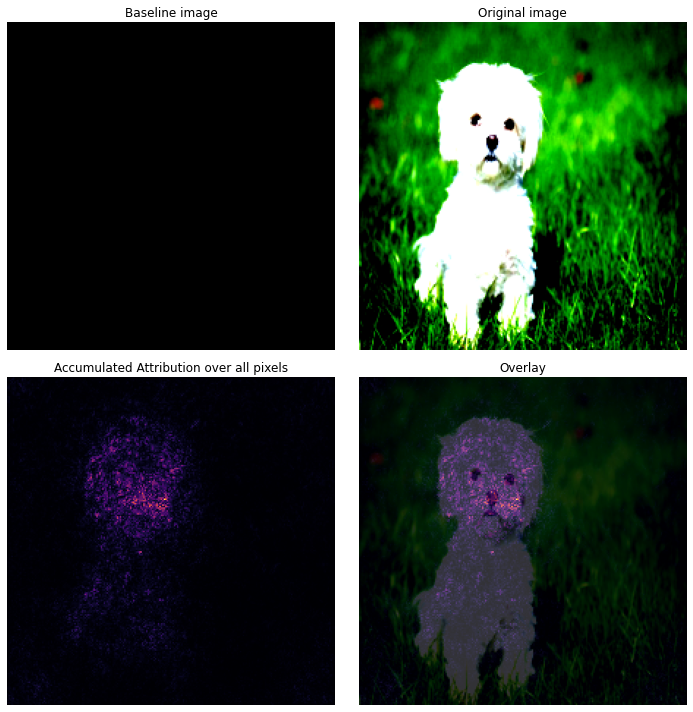

In [16]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image


# Opening the image
img = Image.open('input.jpg') 

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

class IG():
    """
        Compute attribution of classifier's output from each input pixels using 
        Integrated Gradient Methood 
    """
    def __init__(self, model):
        self.model = torchvision.models.vgg19(pretrained=True) 
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def create_images_on_linear_path(self, input_image, steps):
        ''' Create list of all intermediate step images on a linear path
            conneting baseline image to original input image
        '''
        ### YOUR CODE STARTS HERE
        # baseline_img = torch.zeros(input_image.size())
        # path = [baseline_img + alphas * (input_image - baseline_img) for alphas in np.linspace(0,1,steps+1)]
        # return path

        # Generate uniform numbers between 0 and steps
        step_list = np.arange(steps+1)/steps
        # Generate scaled xbar images
        xbar_list = [input_image*step for step in step_list]
        return xbar_list
        #alphas = np.linspace(0.0, 1.0, num = steps+1, endpoint=True)
        ### YOUR CODE ENDS HERE

    def compute_gradients(self, input_image, target_class):
        ''' Compute gradient of model's target class output w.r.t to all input pixels'''  

        ### YOUR CODE STARTS HERE
        
        output = self.model(input_image)
        # clear grad
        self.model.zero_grad()
        #for backprop
        target = torch.FloatTensor(1, output.size()[-1]).zero_()
        target[0][target_class] = 1
        #backprop
        output.backward(gradient = target)
        #gradient to numpy array
        grad = self.gradients.data.numpy()[0]
        
        return grad

        ### YOUR CODE ENDS HERE

    def compute_integrated_gradients(self, input_image, target_class, steps):

        ''' Main computation of Integrated Gradient method'''
        # Generate xbar images
        x_list = self.create_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for x_image in x_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.compute_gradients(x_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,224,224)
        return integrated_grads[0]

### YOUR CODE STARTS HERE
if __name__ == '__main__':

    import warnings
    warnings.filterwarnings('ignore')

    ig = IG(model=None)
    integrated_grad = ig.compute_integrated_gradients(input_image=X,target_class=243,steps=5)
    #print(integrated_grad.shape)
    int_grad = np.sum(np.abs(integrated_grad), axis = 0)
    #print(int_grad.shape)
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ax = plt.subplots(nrows = 2, ncols = 2, squeeze = False, figsize = (10,10))
    img1 = X
    img1 = img1.reshape(-1, 224, 224)
    baseline = torch.zeros(img1.size())
    ax[0, 0].set_title("Baseline image")
    ax[0, 0].imshow(baseline.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0, 0].axis('off')
    ax[0, 1].set_title("Original image")
    ax[0, 1].imshow(img1.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0, 1].axis('off')
    ax[1, 0].set_title("Accumulated Attribution over all pixels")
    ax[1, 0].imshow(int_grad, cmap=plt.cm.inferno)
    ax[1, 0].axis('off')
    ax[1, 1].set_title("Overlay")
    ax[1, 1].imshow(int_grad, cmap=plt.cm.inferno)
    ax[1, 1].imshow(img1.cpu().detach().numpy().transpose(1, 2, 0), alpha = 0.2)
    ax[1, 1].axis('off')
    plt.tight_layout()
### YOUR CODE ENDS HERE

### Question 4

For the given input image, find out and print the channel index and the importance(weight) score of the most important feauture map (out of all the feature maps of final convolution layer of a pretrained ResNet50 model) using Grad-CAM method for the class prediction corresponding to "highest logit score". Note that, Grad-CAM produces final heatmap using the weighted combination of the feature map activations, where weights correspond to importance score.



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Most important feature map index:  708
Its corresponding importance is:  0.0046336893


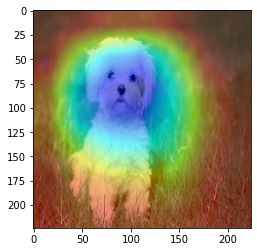

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models


def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)
        print(self.feature_extractor)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE
        if self.cuda:
            input = input.cuda()

        features, output = self.extractor(input)

        if target_index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return weights, cam
        ### YOUR CODE ENDS HERE


if __name__ == '__main__':
    
    image = cv2.imread('input.jpg', 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet50(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=False)
    

    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index: ", np.argmax(weights))
    print ("Its corresponding importance is: ", np.max(weights))

    visualize(image, class_activation_map)